In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [35]:
rdmc = pd.read_csv('rDMC_long_v1.csv')
rdmc = rdmc.drop('Unnamed: 0', axis=1)
rdmc = rdmc.sort_values(by=['country', 'year'])

exclude_tek = ['air defence_air to air missiles', 'air defence_surface to air artillery', 'aircraft_attack', 
       'aircraft_comm', 'aircraft_paramilitary', 'anti-tank/anti-infrastructure_artillery', 
       'anti-tank/anti-infrastructure_missiles', 'armoured fighting vehicles_engineering and maintenance',
       'ballistic missiles_medium-range', 'ballistic missiles_short-range', 'helicopters_ew', 
       'helicopters_observation', 'helicopters_search and rescue', 'land/sea defence_air to surface ordnance',
       'logistics and support_transport', 'mine warfare_mine layers', 'patrol and coastal combatants_other',
       'radars_communications', 'radars_environmental', 'radars_fire control', 'radars_navigation', 
       'submarines_coastal', 'submarines_other', 'unmanned aerial vehicles_combat', 
       'unmanned aerial vehicles_transport', 'logistics and support_yard craft', 'amphibious_other', 
       'logistics and support_training']

# excluding years / technologies that don't have data
rdmc = rdmc[~rdmc['tek'].isin(exclude_tek)]
rdmc = rdmc[rdmc['unit_count'] != 0]

rdmc_maxes = rdmc.groupby('tek').agg({'unit_count': 'max'}).reset_index()
rdmc_maxes.rename(columns={'unit_count': 'unit_count_max'}, inplace=True)
rdmc = rdmc.merge(rdmc_maxes, how='left', on='tek')
rdmc['normalized'] = rdmc['unit_count'] / rdmc['unit_count_max']
rdmc = rdmc[(rdmc['country'] == 'us') | (rdmc['country'] == 'soviet union') | (rdmc['country'] == 'russia') 
            | (rdmc['country'] == 'ukraine')]

rdmc_tech_score = rdmc.groupby(['stateabb', 'year']).agg({'normalized': 'mean'}).reset_index()
rdmc_tech_score_rus = rdmc_tech_score[rdmc_tech_score['stateabb'] == 'RUS']
rdmc_tech_score_us = rdmc_tech_score[rdmc_tech_score['stateabb'] == 'USA']
rdmc_tech_score_ukr = rdmc_tech_score[rdmc_tech_score['stateabb'] == 'UKR']
rdmc_tech_score_ukr

,stateabb,year,normalized
45,UKR,1992,0.063502
46,UKR,1993,0.060132
47,UKR,1994,0.051058
48,UKR,1995,0.051081
49,UKR,1996,0.032250
50,UKR,1997,0.039723
51,UKR,1998,0.032429
52,UKR,1999,0.022890
53,UKR,2000,0.026887
54,UKR,2001,0.025810


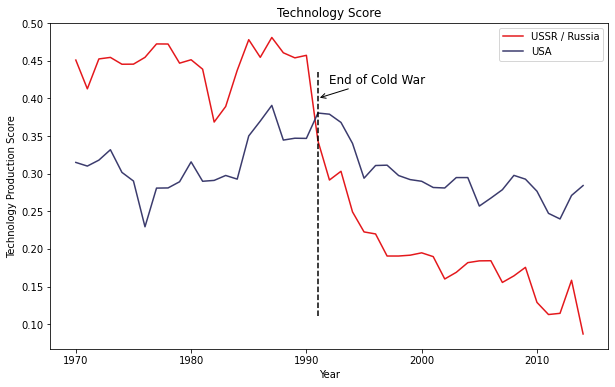

In [48]:
plt.figure(figsize=(10, 6))

plt.plot(rdmc_tech_score_rus['year'], rdmc_tech_score_rus['normalized'], label='USSR / Russia', color='#E4181C')
plt.plot(rdmc_tech_score_us['year'], rdmc_tech_score_us['normalized'], label='USA', color='#3B3B6D')
plt.axvline(x=1991, color='black', ymin=0.1, ymax=0.85, linestyle='--')
plt.annotate('End of Cold War', xy=(1991, .4), xytext=(1992, .42),
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=12, color='black')

plt.xlabel('Year')
plt.ylabel('Technology Production Score')
plt.title('Technology Score')

plt.legend()
plt.show()

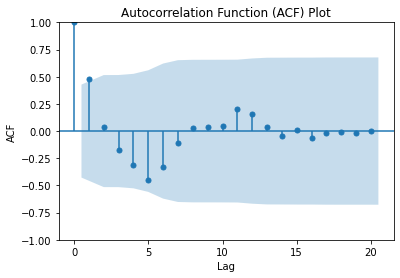

In [22]:
# determining q

sm.graphics.tsa.plot_acf(rdmc_adj_ussr['normalized'], lags=20)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

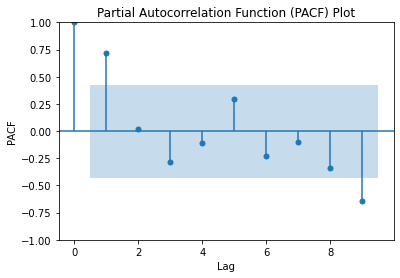

In [23]:
# determining p

sm.graphics.tsa.plot_pacf(rdmc_adj_us['normalized'], lags=9)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()

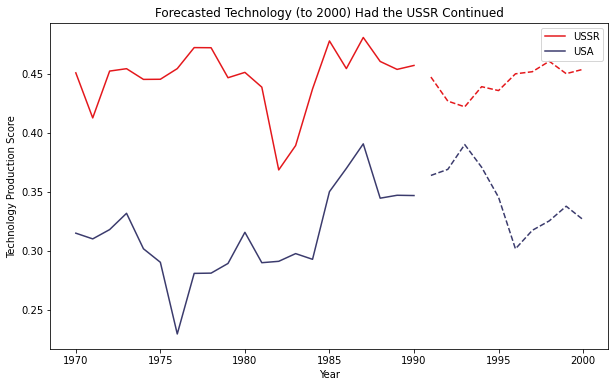

In [50]:
rdmc_adj = rdmc_tech_score.copy()
rdmc_adj = rdmc_adj[rdmc_adj['year'] <= 1990]
rdmc_adj_ussr = rdmc_adj[rdmc_adj['stateabb'] == 'RUS']
rdmc_adj_us = rdmc_adj[rdmc_adj['stateabb'] == 'USA']

rdmc_adj_ussr['year'] = pd.to_datetime(rdmc_adj_ussr['year'], format='%Y')  # Assuming 'year' is in YYYY format
rdmc_adj_ussr.set_index('year', inplace=True)
rdmc_adj_us['year'] = pd.to_datetime(rdmc_adj_us['year'], format='%Y')  # Assuming 'year' is in YYYY format
rdmc_adj_us.set_index('year', inplace=True)

p, d, q = 9, 1, 2  # ARIMA order parameters
forecast_steps = 10

model_ussr = sm.tsa.ARIMA(rdmc_adj_ussr['normalized'], order=(p, d, q))
results_ussr = model_ussr.fit()
forecast_index_ussr = pd.date_range(start=rdmc_adj_ussr.index[-1], periods=forecast_steps + 1, closed='right')
forecast_values_ussr = results_ussr.forecast(steps=forecast_steps)

model_us = sm.tsa.ARIMA(rdmc_adj_us['normalized'], order=(p, d, q))
results_us = model_us.fit()
forecast_index_us = pd.date_range(start=rdmc_adj_us.index[-1], periods=forecast_steps + 1, closed='right')
forecast_values_us = results_us.forecast(steps=forecast_steps)

plt.figure(figsize=(10, 6))
plt.plot(rdmc_adj_ussr.index.year, rdmc_adj_ussr['normalized'], color = '#E4181C', label='USSR')
plt.plot(rdmc_adj_us.index.year, rdmc_adj_us['normalized'], color = '#3B3B6D', label='USA')
plt.plot(range(1991, 1991 + forecast_steps), 
         forecast_values_ussr, color='#E4181C', linestyle='--')
plt.plot(range(1991, 1991 + forecast_steps), 
         forecast_values_us, color='#3B3B6D', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Technology Production Score')
plt.title("Forecasted Technology (to 2000) Had the USSR Continued")
plt.legend()
plt.show()

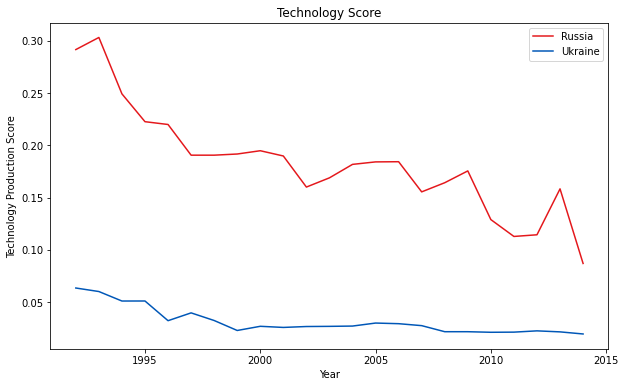

In [47]:
plt.figure(figsize=(10, 6))

rdmc_tech_score_rus_adj = rdmc_tech_score_rus[rdmc_tech_score_rus['year'] >= 1992]

plt.plot(rdmc_tech_score_rus_adj['year'], rdmc_tech_score_rus_adj['normalized'], label='Russia', color='#E4181C')
plt.plot(rdmc_tech_score_ukr['year'], rdmc_tech_score_ukr['normalized'], label='Ukraine', color='#0057B7')

plt.xlabel('Year')
plt.ylabel('Technology Production Score')
plt.title('Technology Score')

plt.legend()
plt.show()